In [37]:
import sklearn.ensemble as ensemble
import sklearn.linear_model as lr
import pandas as pd
import numpy as np
import re

from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [10]:
## Oversampling
from imblearn import over_sampling

In [6]:
# Credit-card kaggle
cc_df = pd.read_csv("creditcard.csv")

In [7]:
# X: features
x_cc = cc_df.iloc[:,1:30]
x_cc = np.array(x_cc)

# Y: labels
y_cc = cc_df['Class'].values

In [8]:
X = x_cc
Y = y_cc

In [9]:
# Original
x_train, x_test, y_train, y_test = train_test_split(
    X,
    Y,
    random_state=42)

In [45]:
# Model + Resampling pipelines
# lr.ElasticNet(random_state=42,),
models = [lr.LogisticRegression(solver='lbfgs',
                                random_state=42,
                                max_iter=1000),
        ensemble.RandomForestClassifier(random_state=42,),
        ensemble.GradientBoostingClassifier(random_state=42,),
        ensemble.AdaBoostClassifier(random_state=42,)]

samplers = [over_sampling.SMOTE(random_state=42, sampling_strategy=0.5),
          over_sampling.ADASYN(random_state=42),
          over_sampling.RandomOverSampler(random_state=42)]

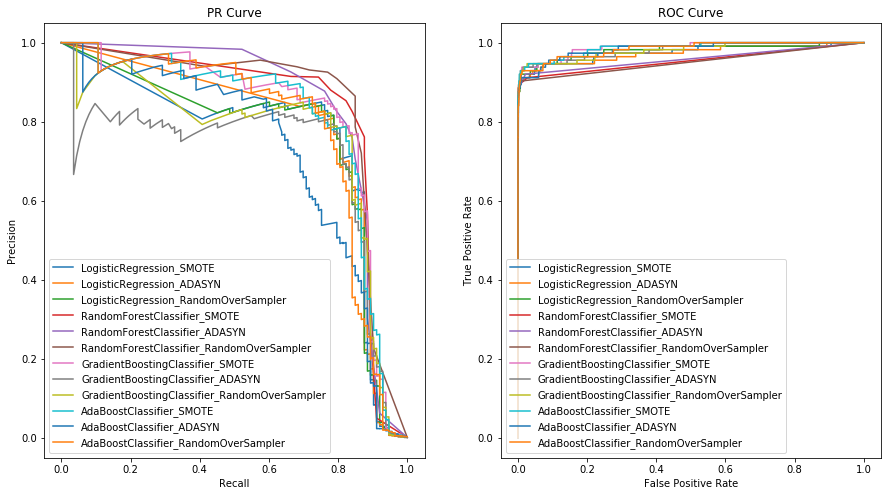

In [48]:
# https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for model in models:
    for sample in samplers:
        
        ## Pipe
        pl = make_pipeline_imb(sample, model)
        
        ## Train
        pl.fit(x_train, y_train)
        
        ## Predict Proba
        pred_prob = pl.predict_proba(x_test)[:,1]
        p,r,_ = precision_recall_curve(y_test,pred_prob)
        tpr,fpr,_ = roc_curve(y_test,pred_prob)
        
        ## Legend
        legend = re.match(r'(.+?)\(.+?',str(model)).group(1) + '_' + re.match(r'(.+?)\(.+?',str(sample)).group(1)
        
        ## Plot
        ax1.plot(r, p, label=legend)
        ax2.plot(tpr, fpr, label=legend)
        
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()

In [49]:
# Evaluate original and resampled
from imblearn.metrics import classification_report_imbalanced

In [50]:
for model in models:
    for sample in samplers:
        ## Pipe
        pl = make_pipeline_imb(sample, model)
        
        ## Legend
        legend = re.match(r'(.+?)\(.+?',str(model)).group(1) + '_' + re.match(r'(.+?)\(.+?',str(sample)).group(1)
        
        print(legend)
        print(classification_report_imbalanced(y_test, pl.predict(x_test)))

LogisticRegression_SMOTE
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.92      0.99      0.95      0.90     71089
          1       0.06      0.92      0.98      0.11      0.95      0.89       113

avg / total       1.00      0.98      0.92      0.99      0.95      0.90     71202

LogisticRegression_ADASYN
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.92      0.99      0.95      0.90     71089
          1       0.06      0.92      0.98      0.11      0.95      0.89       113

avg / total       1.00      0.98      0.92      0.99      0.95      0.90     71202

LogisticRegression_RandomOverSampler
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.92      0.99      0.95      0.90     71089
          1       0.06      0.92      0.98      0.11      0.95      0.89   